In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Deep Learning Book

# Chapter 10 Sequence Modeling

RNN operates on a **sequence** that contains **vectors** $x^{(t)}$ with the time step index $t$ ranging from 1 to $\tau$. 

In practice, RNNs usually operate on minibatches of such sequences, with a different length $\tau$ for each member of the minibatch.

## TODO 

check out this [video](https://www.youtube.com/watch?v=Ukgii7Yd_cU) from Intel Nervana.

Hinton's course on [Coursera](https://www.coursera.org/learn/neural-networks#syllabus) on RNNs. 

FastAI's course on [RNN](http://course.fast.ai/lessons/lesson6.html)

# Vanishing or Exploding Gradients

Biggest eigenvalue 

## RNN Computation

Video from Stanford's [cs224d](https://www.youtube.com/watch?v=MeIrQCZvlkE&t=3990s) on RNN. And [here](https://www.youtube.com/watch?v=Keqep_PKrY8) for the 2017 version.

My notes for Stanford's [cs231n](./cs231n.ipynb#rnn).

Given list of word vectors: $x_1, x_2, \cdots, x_t, \cdots, x_T$

At single time step: 

$$
\begin{aligned}
h_t &= \sigma\bigg( W_{hh} h_{t-1} + W_{hx} x_t \bigg) \\
\hat{y}_t &= softmax\bigg(W_{S} h_t\bigg) \\
\hat{P}(x_{t+1} = v_j \mid x_t, \cdots, x_1) &= \hat{y}_{t,j} \\
W_{hh} &\in \mathbb{R}^{D_h \times D_h} \\
W_{hx} &\in \mathbb{R}^{D_h \times d} \\
W_{S} &\in \mathbb{R}^{V \times D_h}
\end{aligned}
$$

For computation of $f(z_1 + z_2) = f(W_1 x_1 + W_2 x_2)$, form the following matricies:

$$
\begin{aligned}
W' &= concat(W_1, W_2, axis=1) \\
X' &= concat(x_1, x_2, axis=0) \\
f(W_1 x_1 + W_2 x_2) &= f(W'X')
\end{aligned}
$$

If $W_1$ is $N \times N$, $W'$ is $N \times 2N$, i.e. concat **horizontally**.

If $x_1$ is $N \times 1$, $X'$ is $2N \times 1$, i.e. concat **vertically**.

## Teacher Forcing, p372

A RNN whose only recurrence is the feedback connection from the output of the hidden layer, not the hidde layer itself, is **less powerful** than those which have direct connection from hidden layer $h^{(t-1)}$ to $h^{(t)}$. p370.

The advantage of eliminating hidden-to-hidden recurrence is that, for any loss function based on comparing the prediction at time $t$ to the training target at time $t$, all the time steps are decoupled. Tranining can thus be parallelized, with gradient for each step t computed in isolation.

Teacher forcing is a procedure that emerges from the maximum likelihood criterion, in which during training the model receives the ground truth output $y^{(t)}$ as input at time $t+1$, instead of the output from the previous step, thus parallelizing training.

## BPTT

The backprop algorithm applied to the unrolled graph with $\mathbb{O}(\tau)$ cost is called **back-propagation through time (BPTT)**. As soon as the hidden units become a function of earlier time steps, the BPTT algorithm is necessary.

Example is based on the RNN architecture given in figure 10.3 on page 369. This network is described as:

$$
\begin{aligned}
a^{(t)} &= b + W h^{(t-1)} + U x^{(t)}, &(10.8)\\
h^{(t)} &= \tanh\big(a^{(t)}\big), &(10.9)\\
o^{(t)} &= c + V h^{(t)}, &(10.10)\\
\hat{y}^{(t)} &= \text{softmax}\big( o^{(t)} \big), &(10.11)
\end{aligned}
$$

Where:

* $x$ are input sequences
* $o$ outputs of corresponding $x$
* $y$ training target for corresponding $x$
* $U$ weight matrix for input-to-hidden connections
* $W$ weight matrix for hidden-to-hidden connections
* $V$ weight matrix for hidden-to-output connections

First, **derivate of `softmax(x)`**, see this [post](http://peterroelants.github.io/posts/neural_network_implementation_intermezzo02/), using the quotient rule:

$$ \big(\frac{f}{g}\big)' = \frac{f'g - fg'}{g^2} $$

Let $f = e^x$, $g = \sum_i e^{x_i}$, $y = \text{softmax}(x)$ and $y_i$ be the result for $x_i$, $x \in R^n$.

For $i = j$:

$$
\begin{aligned}
\frac{\partial y_i}{\partial x_i} &= \frac{e^{x_i} g - e^{x_i} (0 + \cdots + e^{x_i} + 0 + \cdots + 0)}{g^2} \\
&= \frac{e^{x_i} g - e^{x_i} e^{x_i}}{g^2} \\
&= \frac{e^{x_i} (g - e^{x_i})}{g^2} \\
&= \frac{e^{x_i}}{g} \times \frac{g - e^{x_i}}{g}\\
&= y_i \times (1 - \frac{e^{x_i}}{g}) \\
&= y_i \times (1 - y_i)
\end{aligned}
$$

For $i \neq j$:

$$
\begin{aligned}
\frac{\partial y_i}{\partial x_j} &= \frac{0 \times g - e^{x_i} e^{x_j}}{g^2} \\
&= -\frac{e^{x_i}}{g} \frac{e^{x_j}}{g} \\
&= - y_i y_j
\end{aligned}
$$

Back to BPTT, we start from the node immediately preceding the final loss:

$$ \frac{\partial L}{\partial L^{t}} = 1 $$

Then we have

$$(\triangledown_{o^{t}}L)_i = \frac{\partial L}{\partial o^{t}_i} = \frac{\partial L}{\partial L^{t}} \frac{\partial L^{t}}{\partial o^{t}_i} = \hat{y}^{(t)}_i - 1_{i,y^{(t)}} $$

# LSTM - Long Short-Term Memory

Chris Olah's [post](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)

**Nando De Freitas**'s [lecture](https://www.youtube.com/watch?v=56TYLaQN4N8&list=PLE6Wd9FR--EfW8dtjAuPoTuPcqmOV53Fu&index=14): parameter updates act like writing to memory. We need a way to decide when to read, write and erase the memory. Hence we arrive at LSTM, which learns from the data when to read, write and erase.

Components of LSTM cell:

## Forget gate 

Decides what info we are going to throw away from the cell state. 

* Inputs: $h_{t-1}$ from the same layer, input $x_t$ or $h_t$ from the previous layer.
* Output: a number between 0 and 1 for each number in the cell state $C_{t-1}$. 1 is keep everything, 0 is forget everything.

$$ f_t = \sigma\big( W_f \times [ h_{t-1}, x_t] + b_f\big) $$

## Input Gate, tanh layer

Next step is to decide what new info we are going to store in the cell state, done in two parts. 
* Input gate
* tanh layer

$$
\begin{aligned}
i_t &= \sigma\big( W_i \times [h_{t-1}, x_t] + b_i \big) \\
\tilde{C}_t &= \tanh \big( W_C \times [h_{t-1}, x_t] + b_C \big)
\end{aligned}
$$

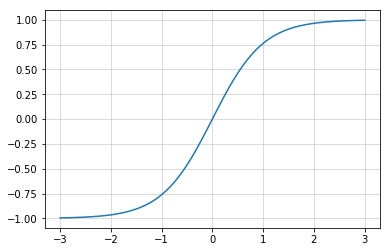

In [6]:
x = np.linspace(-3, 3, num=100)
y = np.tanh(x)
plt.plot(x, y)

## Cell State

Next step is to update the **old** cell state, $C_{t-1}$, into the **new** cell state $C_t$. Inputs are the outputs from **forget gate**, **input gate**, and **tanh layer**. $\odot$ represents element-wise multiplication.

$$ C_t = f_t \odot C_{t-1} + i_t \odot \tilde{C}_t $$

# Ouput 

Work out the output of the cell, using sigmoid to decide which parts of the cell state we are going to output. 

$$
\begin{aligned}
o_t &= \sigma \big( W_o \times [h_{t-1}, x_t] + b_o \big) \\
h_t &= o_t \odot \tanh(C_t)
\end{aligned}
$$

## Formula Summary

$$
\begin{aligned}
i_t &= \sigma\big( W_i \times [h_{t-1}, x_t] + b_i \big) \\
f_t &= \sigma\big( W_f \times [ h_{t-1}, x_t] + b_f\big) \\
o_t &= \sigma \big( W_o \times [h_{t-1}, x_t] + b_o \big) \\
g = \tilde{C}_t &= \tanh \big( W_C \times [h_{t-1}, x_t] + b_C \big) \\
C_t &= f_t \odot C_{t-1} + i_t \odot \tilde{C}_t \\
h_t &= o_t \odot \tanh(C_t)
\end{aligned}
$$

## Layers

Parameters in the same layer are shared in all recurrent steps. Different layers will have different parameters.

# LSTM Variants

## Gers & Schmidhuber (2000)

 Add **peephole connections**, allowing the gates to look at the cell state. Modifications:
 
$$
\begin{aligned}
f_t &= \sigma \big( W_f \times [C_{t-1}, h_{t-1}, x_t] + b_f \big) \\
i_t &= \sigma \big( W_i \times [C_{t-1}, h_{t-1}, x_t] + b_i \big) \\
o_t &= \sigma \big( W_o \times [C_{t}, h_{t-1}, x_t] + b_o \big) \\
\end{aligned}
$$

## Coupled Forget and Input Gates

Make **forget** and **input** (cell update) gates make decision together.

$$ C_t = f_t \odot C_{t-1} + (1-f_t) \odot \tilde{C}_t $$

## GRU (Gated Recurrent Unit)

Combines **forget** and **input** gates into a single **update** gate, merges **cell state** and **hidden state**, plus othe changes. 

* Input: $h_{t-1}$, $x_t$
* Output: $h_t$

It is simpler than the standard LSTM, increasingly popular. 

$$
\begin{aligned}
z_t &= \sigma \big( W_z \times [h_{t-1}, x_t] \big) \\
r_t &= \sigma \big( W_r \times [h_{t-1}, x_t] \big) \\
\tilde{h}_t &= \tanh \big( W \times [r_t \times h_{t-1}, x_t] \big) \\
h_t &= (1 - z_t) \times h_{t-1} + z_t \times \tilde{h}_t
\end{aligned}
$$


Next big step is **attention**. This is as of 2015. See Olah's other [post](https://distill.pub/2016/augmented-rnns/)

More on RNN, Andrea Karpathy's [post](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)